In [ ]:
import pandas as pd
import numpy as np
import os
import random
from glob import glob
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
clinical_df = pd.read_excel('/content/drive/MyDrive/content/patient-clinical-data.xlsx')

In [ ]:
clinical_df = clinical_df[['Patient ID', 'ALN status', 'Age(years)', 'Tumour Size(cm)', 'Ki67']].dropna()

In [ ]:
clinical_df

,Patient ID,ALN status,Age(years),Tumour Size(cm),Ki67
0,1,N0,77,3.0,0.01
1,2,N+(>2),39,3.5,0.40
2,3,N+(>2),52,3.0,0.06
3,4,N0,60,2.3,0.60
4,5,N0,71,3.5,0.12
...,...,...,...,...,...
1053,1054,N0,60,2.0,0.20
1054,1055,N0,63,2.0,0.10
1055,1056,N0,62,2.0,30.00
1056,1057,N+(>2),46,4.0,0.70


In [ ]:
le = LabelEncoder()
clinical_df['label'] = le.fit_transform(clinical_df['ALN status'])
class_names = le.classes_
print("Classes:", class_names)

Classes: ['N+(1-2)' 'N+(>2)' 'N0']


In [ ]:
scaler = StandardScaler()
clinical_df[['Age(years)', 'Tumour Size(cm)', 'Ki67']] = scaler.fit_transform(clinical_df[['Age(years)', 'Tumour Size(cm)', 'Ki67']])

In [ ]:
clinical_df

,Patient ID,ALN status,Age(years),Tumour Size(cm),Ki67,label
0,1,N0,1.551018,0.888395,-0.217270,2
1,2,N+(>2),-1.483477,1.468332,-0.170899,1
2,3,N+(>2),-0.445361,0.888395,-0.211325,1
3,4,N0,0.193481,0.076484,-0.147119,2
4,5,N0,1.071887,1.468332,-0.204191,2
...,...,...,...,...,...,...
1053,1054,N0,0.193481,-0.271479,-0.194679,2
1054,1055,N0,0.433046,-0.271479,-0.206569,2
1055,1056,N0,0.353191,-0.271479,3.348565,2
1056,1057,N+(>2),-0.924491,2.048269,-0.135229,1


In [ ]:
from google.colab import drive
#drive.mount('/content/drive/MyDrive/content/gdrive')
!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive

/mydrive


In [ ]:
!unzip /content/drive/MyDrive/content/gdrive/patches.zip

Streaming output truncated to the last 5000 lines.
  inflating: patches/96/96_2_1280_1024.jpg  
  inflating: patches/96/96_2_1280_1280.jpg  
  inflating: patches/96/96_2_1280_1536.jpg  
  inflating: patches/96/96_2_1280_1792.jpg  
  inflating: patches/96/96_2_1280_2048.jpg  
  inflating: patches/96/96_2_1536_1024.jpg  
  inflating: patches/96/96_2_1536_1280.jpg  
  inflating: patches/96/96_2_1536_1536.jpg  
  inflating: patches/96/96_2_1536_1792.jpg  
  inflating: patches/96/96_2_1536_2048.jpg  
  inflating: patches/96/96_2_1792_1024.jpg  
  inflating: patches/96/96_2_1792_1280.jpg  
  inflating: patches/96/96_2_1792_1536.jpg  
  inflating: patches/96/96_2_1792_1792.jpg  
  inflating: patches/96/96_2_1792_768.jpg  
  inflating: patches/96/96_2_2048_1024.jpg  
  inflating: patches/96/96_2_2048_1280.jpg  
  inflating: patches/96/96_2_2048_1536.jpg  
  inflating: patches/96/96_2_2048_1792.jpg  
  inflating: patches/96/96_2_2048_512.jpg  
  inflating: patches/96/96_2_2048_768.jpg  
  infla

In [ ]:
#Run this code if you want to train all the images

def get_image_paths(patient_id):
    return glob(f'/content/patches/{patient_id}/*.jpg')


In [ ]:
#def get_image_paths(patient_id, max_per_patient=30):
  #  all_paths = glob(f'/content/patches/{patient_id}/*.jpg')
  #  return random.sample(all_paths, min(len(all_paths), max_per_patient))

clinical_df['image_paths'] = clinical_df['Patient ID'].apply(get_image_paths)
clinical_df = clinical_df[clinical_df['image_paths'].map(len) > 0]

In [ ]:
clinical_df

,Patient ID,ALN status,Age(years),Tumour Size(cm),Ki67,label,image_paths
0,1,N0,1.551018,0.888395,-0.217270,2,"[/content/patches/1/1_3_768_256.jpg, /content/..."
1,2,N+(>2),-1.483477,1.468332,-0.170899,1,"[/content/patches/2/2_0_512_768.jpg, /content/..."
2,3,N+(>2),-0.445361,0.888395,-0.211325,1,"[/content/patches/3/3_1_256_1024.jpg, /content..."
3,4,N0,0.193481,0.076484,-0.147119,2,"[/content/patches/4/4_7_256_256.jpg, /content/..."
4,5,N0,1.071887,1.468332,-0.204191,2,"[/content/patches/5/5_7_0_0.jpg, /content/patc..."
...,...,...,...,...,...,...,...
1053,1054,N0,0.193481,-0.271479,-0.194679,2,"[/content/patches/1054/1054_0_512_0.jpg, /cont..."
1054,1055,N0,0.433046,-0.271479,-0.206569,2,"[/content/patches/1055/1055_1_1792_768.jpg, /c..."
1055,1056,N0,0.353191,-0.271479,3.348565,2,"[/content/patches/1056/1056_4_0_0.jpg, /conten..."
1056,1057,N+(>2),-0.924491,2.048269,-0.135229,1,"[/content/patches/1057/1057_0_1280_768.jpg, /c..."


In [ ]:
all_images = []
all_labels = []
all_clinical = []

for _, row in clinical_df.iterrows():
    label = row['label']
    clinical_features = row[['Age(years)', 'Tumour Size(cm)', 'Ki67']].values.astype(np.float32)
    for img_path in row['image_paths']:
        all_images.append(img_path)
        all_labels.append(label)
        all_clinical.append(clinical_features)

train_imgs, val_imgs, train_labels, val_labels, train_clinical, val_clinical = train_test_split(
    all_images, all_labels, all_clinical, test_size=0.2, stratify=all_labels, random_state=42)


In [ ]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

In [ ]:
def process_image_and_clinical(img_path, clinical_feat, label, augment=False):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    if augment:
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_brightness(img, 0.2)
        img = tf.image.random_contrast(img, 0.8, 1.2)
    img = preprocess_input(img)
    return (img, clinical_feat), label

def create_dataset(image_paths, clinical_feats, labels, shuffle=True, augment=False):
    ds = tf.data.Dataset.from_tensor_slices((image_paths, clinical_feats, labels))
    ds = ds.map(lambda x, y, z: process_image_and_clinical(x, y, z, augment), num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(1000)
    return ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_ds = create_dataset(train_imgs, train_clinical, train_labels, shuffle=True, augment=True)
val_ds = create_dataset(val_imgs, val_clinical, val_labels, shuffle=False, augment=False)

In [ ]:

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights_dict = {i: w for i, w in enumerate(class_weights)}
print("Class weights:", class_weights_dict)

Class weights: {0: np.float64(1.8459915611814346), 1: np.float64(1.919400833568362), 2: np.float64(0.5161850344263815)}


In [ ]:

image_input = Input(shape=(*IMG_SIZE, 3), name='image_input')
base_model = EfficientNetB0(include_top=False, input_tensor=image_input, weights='imagenet')
base_model.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)

clinical_input = Input(shape=(3,), name='clinical_input')
combined = Concatenate()([x, clinical_input])
combined = Dense(128, activation='relu')(combined)
combined = Dropout(0.3)(combined)
output = Dense(len(class_names), activation='softmax')(combined)

model = Model(inputs=[image_input, clinical_input], outputs=output)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Path to save the best model
checkpoint_path = '/content/drive/MyDrive/content/best_efficientnet_model.keras'

# Create a ModelCheckpoint callback
checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',       # monitor validation accuracy
    mode='max',                   # we want to maximize accuracy
    save_best_only=True,          # only save if val_accuracy improves
    verbose=1                     # prints a message when saving
)

# Training with callback
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    class_weight=class_weights_dict,
    callbacks=[checkpoint]       # add the checkpoint callback here
)

Epoch 1/100
1915/1915 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.3904 - loss: 1.1091
Epoch 1: val_accuracy improved from -inf to 0.47267, saving model to /content/drive/MyDrive/content/best_efficientnet_model.keras
1915/1915 ━━━━━━━━━━━━━━━━━━━━ 199s 89ms/step - accuracy: 0.3904 - loss: 1.1090 - val_accuracy: 0.4727 - val_loss: 1.0249
Epoch 2/100
1914/1915 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.4938 - loss: 1.0129
Epoch 2: val_accuracy improved from 0.47267 to 0.53471, saving model to /content/drive/MyDrive/content/best_efficientnet_model.keras
1915/1915 ━━━━━━━━━━━━━━━━━━━━ 144s 66ms/step - accuracy: 0.4938 - loss: 1.0129 - val_accuracy: 0.5347 - val_loss: 0.9741
Epoch 3/100
1915/1915 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.5364 - loss: 0.9755
Epoch 3: val_accuracy improved from 0.53471 to 0.55952, saving model to /content/drive/MyDrive/content/best_efficientnet_model.keras
1915/1915 ━━━━━━━━━━━━━━━━━━━━ 122s 63ms/step - accuracy: 0.5364 - loss: 0.9755 - val_accu

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint


In [ ]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()


NameError: name 'history' is not defined

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━

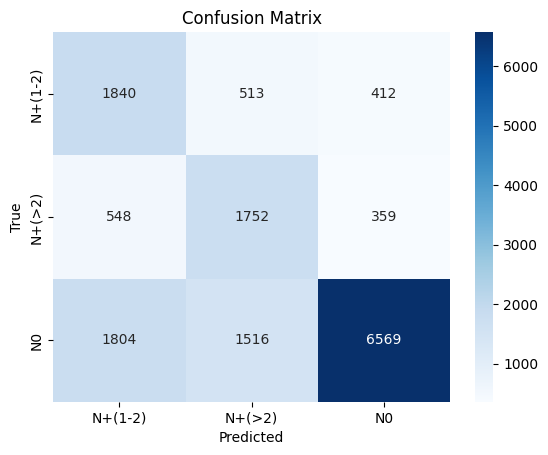

In [ ]:
# Evaluation
val_preds = []
val_true = []
for (images, clinical), labels in val_ds:
    preds = model.predict([images, clinical])
    val_preds.extend(np.argmax(preds, axis=1))
    val_true.extend(labels.numpy())

print(classification_report(val_true, val_preds, target_names=class_names))
cm = confusion_matrix(val_true, val_preds)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/content/best_efficientnet_model.keras')

def preprocess_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = preprocess_input(img)
    return img

def predict_patient_folder(folder_path, age, tumor_size, ki67, max_images=35):
    image_paths = glob(os.path.join(folder_path, '*.jpg'))
    image_paths = random.sample(image_paths, min(len(image_paths), max_images))
    images = np.array([preprocess_image(p).numpy() for p in image_paths])
    clinical_data = np.array([[age, tumor_size, ki67]] * len(images), dtype=np.float32)
    clinical_data = scaler.transform(clinical_data)
    preds = model.predict([images, clinical_data])
    pred_classes = np.argmax(preds, axis=1)
    majority_class = np.bincount(pred_classes).argmax()
    aln_status = class_names[majority_class]
    print(f"Predicted ALN Status: {aln_status}")
    return aln_status

In [ ]:
predict_patient_folder('/content/patches/9', age=57, tumor_size=4.5, ki67=0.2)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 24s 24s/step
Predicted ALN Status: N+(>2)


'N+(>2)'